In [1]:
import pandas as pd
import numpy as np
import statistics
from datetime import datetime
import datetime
import random
import itertools
from scipy.stats import norm
#import seaborn as sns
import math
import random
import sklearn
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [2]:
#Lauras path
#data= pd.read_csv(r'C:\Users\moreno.l.5\Procter and Gamble\Idigoras, Anne - Project\Shipments\total shipments.csv')
#Annes path
data= pd.read_csv(r'C:\Users\idigoras.a\OneDrive - Procter and Gamble\05. Trainings&Acces\FODS 3\Project\Shipments\shipments_2022_2023_2024_Fabric_Baby_Hair.csv')
data = data[data['Sub Sector'] == 'BABY']
#data = data.drop(columns=['Sub Sector','Category'])
#data = data.groupby('Date').sum()
data = data.drop(columns=['Category'])
data = data.rename(columns={'Day Date (Real)': 'Date'})
categories = data['Sub Sector'].unique()
data.head()



,Sub Sector,Shipment MSU Internal,Date
306,BABY,3.4420,2022-01-03 00:00:00
307,BABY,0.4999,2022-01-04 00:00:00
308,BABY,0.8493,2022-01-05 00:00:00
309,BABY,1.1187,2022-01-07 00:00:00
310,BABY,0.3397,2022-01-08 00:00:00


In [3]:


# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' column as the index
data.set_index('Date', inplace=True)

# Create a dictionary specifying aggregation methods for each column
aggregation = {'Sub Sector': 'first', 'Shipment MSU Internal': 'sum'}

# Convert daily data to weekly by resampling and applying aggregation
data = data.resample('W').agg(aggregation)

# Reset index if needed
data = data.reset_index()

print(data)


          Date Sub Sector  Shipment MSU Internal
0   2022-01-09       BABY                22.9573
1   2022-01-16       BABY                25.3695
2   2022-01-23       BABY                24.1727
3   2022-01-30       BABY                18.1986
4   2022-02-06       BABY                22.9444
..         ...        ...                    ...
120 2024-04-28       BABY                16.5507
121 2024-05-05       BABY                16.4453
122 2024-05-12       BABY                19.2233
123 2024-05-19       BABY                20.7189
124 2024-05-26       BABY                12.0080

[125 rows x 3 columns]


In [4]:
# Creating date range in correct format
idx = pd.to_datetime(data['Date'], format='%Y-%m')

# Creating series with correct dates and units sold
ts = pd.Series(data['Shipment MSU Internal'].tolist(), index=idx)

ts

Date
2022-01-09    22.9573
2022-01-16    25.3695
2022-01-23    24.1727
2022-01-30    18.1986
2022-02-06    22.9444
               ...   
2024-04-28    16.5507
2024-05-05    16.4453
2024-05-12    19.2233
2024-05-19    20.7189
2024-05-26    12.0080
Length: 125, dtype: float64

In [5]:
import matplotlib.pylab as plt
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from pylab import rcParams

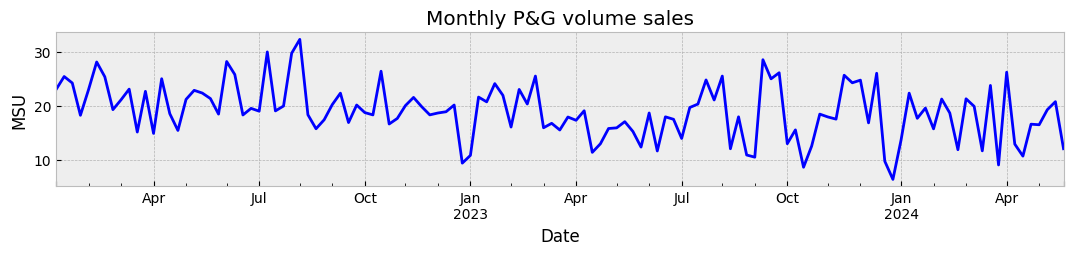

In [6]:
plt.style.use('bmh')

ax = ts.plot(color = 'blue', figsize=(13,2))

ax.set_ylabel('MSU')
ax.set_title('Monthly P&G volume sales')

plt.show()

In [7]:
ts.index

DatetimeIndex(['2022-01-09', '2022-01-16', '2022-01-23', '2022-01-30',
               '2022-02-06', '2022-02-13', '2022-02-20', '2022-02-27',
               '2022-03-06', '2022-03-13',
               ...
               '2024-03-24', '2024-03-31', '2024-04-07', '2024-04-14',
               '2024-04-21', '2024-04-28', '2024-05-05', '2024-05-12',
               '2024-05-19', '2024-05-26'],
              dtype='datetime64[ns]', name='Date', length=125, freq=None)

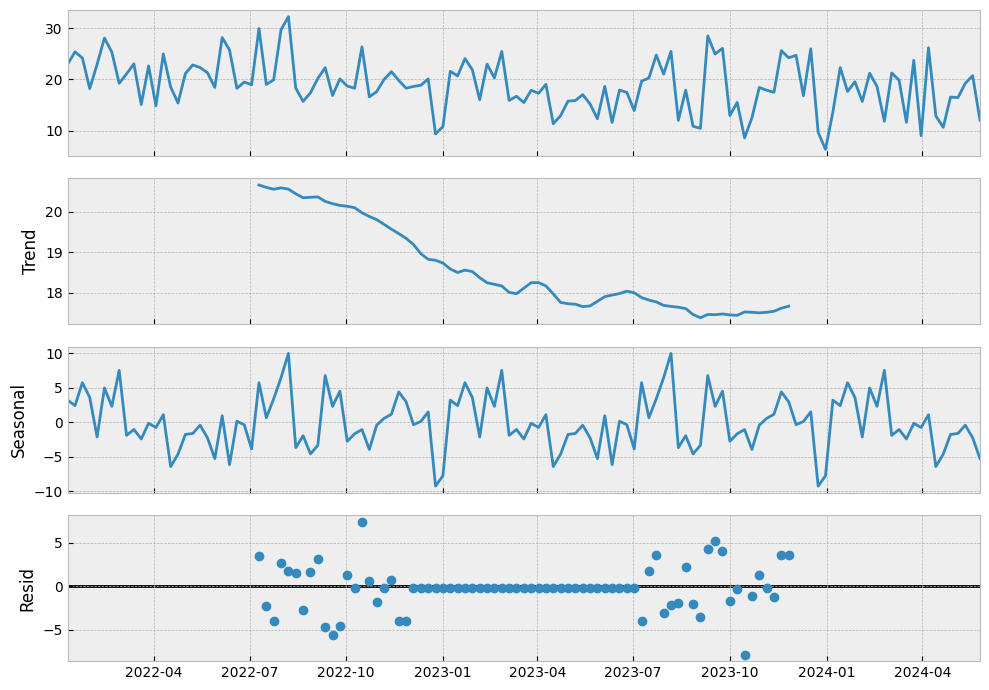

In [8]:
ts = ts.asfreq(pd.infer_freq(ts.index))

rcParams['figure.figsize'] = 10, 7

# Use the seasonal_decompose function
decomposition = sm.tsa.seasonal_decompose(ts)

fig = decomposition.plot()

plt.show()

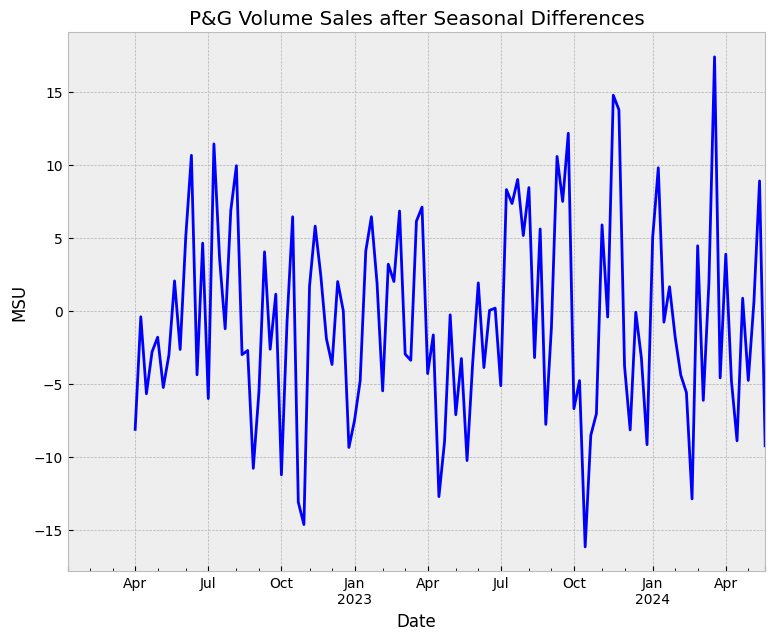

In [9]:
# Use the diff() function to resolve the seasonality first
season_diff = ts.diff(12)

ax = season_diff.plot(color = 'blue', figsize=(9,7))

ax.set_ylabel('MSU')

ax.set_title('P&G Volume Sales after Seasonal Differences')

plt.show()

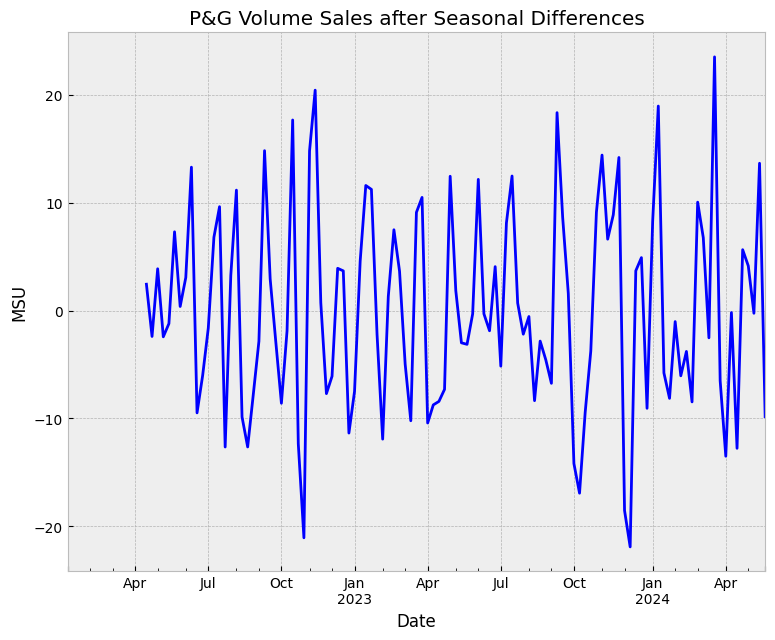

In [10]:
# Use the diff() function to resolve the trend
trend_and_season_diff = season_diff.diff(2)

ax = trend_and_season_diff.plot(color = 'blue', figsize=(9,7))

ax.set_ylabel('MSU')

ax.set_title('P&G Volume Sales after Seasonal Differences')

plt.show()

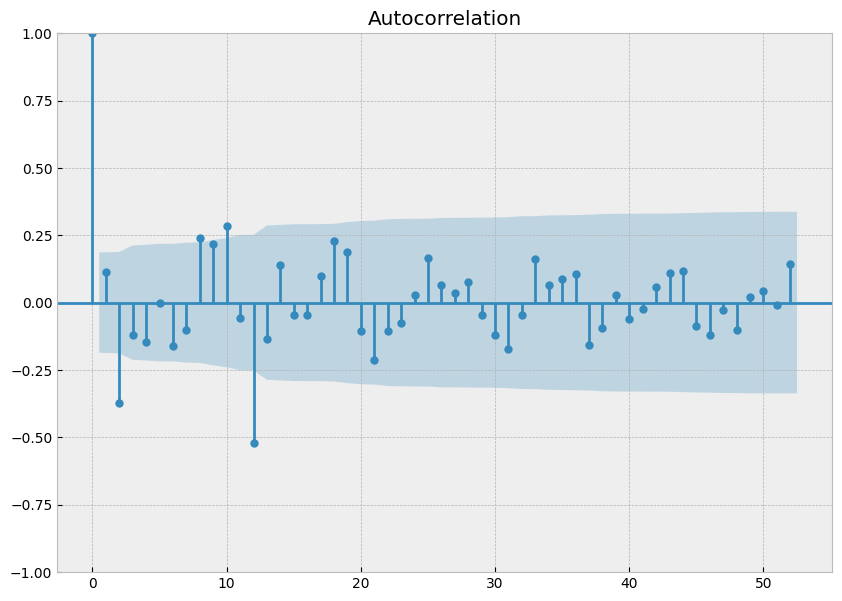

In [11]:
#Remember that the correlation functions cannot handle missing values which you might have after differencing.
season_diff = season_diff.dropna()
trend_and_season_diff = trend_and_season_diff.dropna()

# Use a function from the tsaplots module of statsmodels
fig = tsaplots.plot_acf(trend_and_season_diff, lags = 52)

plt.show()

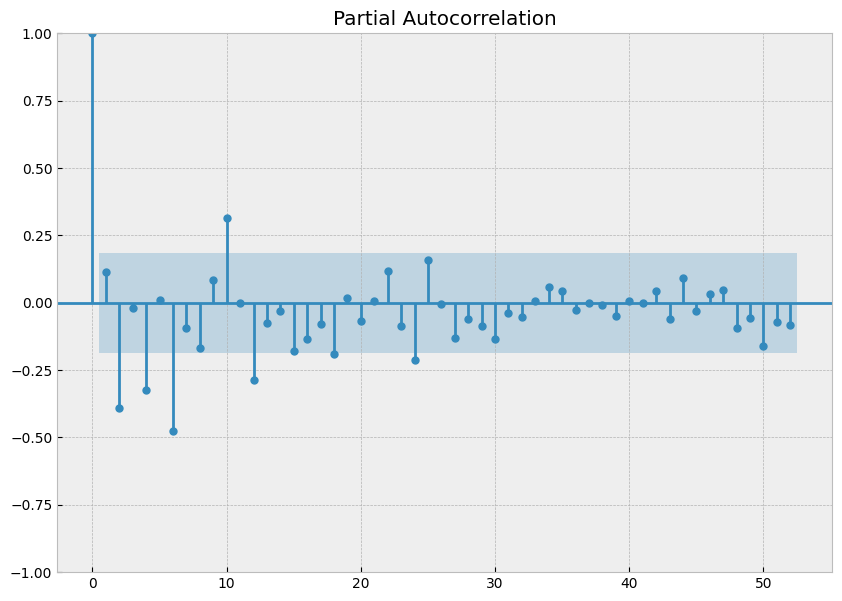

In [12]:
# Use a function from the tsaplots module of statsmodels
fig = tsaplots.plot_pacf(trend_and_season_diff, lags = 52)

plt.show()

In [13]:
# Fill in some possible values for p,d,q, P,D,Q,S
mod_ld = SARIMAX(ts, order=(1,1,0), seasonal_order=(1,1,0,52))

res_ld = mod_ld.fit()
print(res_ld.summary())

c:\Users\idigoras.a\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  125
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 52)   Log Likelihood                -228.590
Date:                            Wed, 29 May 2024   AIC                            463.180
Time:                                    09:43:22   BIC                            470.010
Sample:                                01-09-2022   HQIC                           465.899
                                     - 05-26-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4821      0.112     -4.287      0.000      -0.703      -0.262
ar.S.L52      -0.8459      0.087   